In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json


In [52]:
# https://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except (ValueError, msg):
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [12]:
URL = 'https://blueaccounting.github.io/charts/data/ErieStat_2021_test2.json'
df = pd.read_json(URL)
df["Value"] = pd.to_numeric(df["Value"])
df

,River,Year,Fraction,Value,Source
0,Cattaraugus Creek,2008,Annual TP Loading,NaN,Santina and Maccoux
1,Cattaraugus Creek,2009,Annual TP Loading,44.000000,Santina and Maccoux
2,Cattaraugus Creek,2010,Annual TP Loading,36.000000,Santina and Maccoux
3,Cattaraugus Creek,2011,Annual TP Loading,476.000000,Santina and Maccoux
4,Cattaraugus Creek,2012,Annual TP Loading,559.000000,Santina and Maccoux
...,...,...,...,...,...
1012,Vermilion River,2016,5 Year Average of Percent Reduction Relative t...,42.706439,Santina and Maccoux
1013,Vermilion River,2017,5 Year Average of Percent Reduction Relative t...,44.579125,Santina and Maccoux
1014,Vermilion River,2018,5 Year Average of Percent Reduction Relative t...,60.582326,Santina and Maccoux
1015,Vermilion River,2019,5 Year Average of Percent Reduction Relative t...,66.315317,Santina and Maccoux


In [80]:
# calculate percent reduction and its 5-year average for annual loading and add to 
for u in df['River'].unique():
    # if it's a river with annual loading data going back to 2008
    baseLine = df.loc[(df['River'] == u) & (df['Year'] == 2008)& (df['Fraction'] == 'Annual TP Loading')]
    if len(baseLine) > 0 and pd.notna(baseLine['Value'].iloc[0]):
        print(u)
        appendList = []
        dfu = df.loc[(df['River'] == u) & (df['Fraction'] == 'Annual TP Loading')]
        for index, row in dfu.iterrows():
            # calculate percent reduction relative to 2008 for each year
            print('Value for {} : {}, Baseline Value: {}'.format(row['Year'], row['Value'], baseLine['Value'].iloc[0]))
            pctred = 100*(1-(row['Value']/baseLine['Value'].iloc[0]))
            print(pctred)
            appendList.append([u, row['Year'],'Annual TP Percent Reduction', pctred, 'Santina and Maccoux'])
        # calculate 5-year moving average of percent reduction
        y = [el[3] for el in appendList]
        print(y)
        yhat = savitzky_golay(y, 5, 3) # window size 5, polynomial order 3
        for i in range(len(yhat)):
            appendList.append([u, appendList[i][1], '5 Year Average of Annual TP Percent Reduction', yhat[i], 'Santina and Maccoux'])
        # append list of new values for this river to dataframe
        df_length = len(df)
        for i in range(len(appendList)):
            df.loc[df_length+i] = appendList[i]       



Cuyahoga River
Value for 2008 : 452.0, Baseline Value: 452.0
0.0
Value for 2009 : 398.0, Baseline Value: 452.0
11.946902654867253
Value for 2010 : 269.0, Baseline Value: 452.0
40.48672566371682
Value for 2011 : 468.0, Baseline Value: 452.0
-3.539823008849563
Value for 2012 : 299.0, Baseline Value: 452.0
33.849557522123895
Value for 2013 : 389.0, Baseline Value: 452.0
13.938053097345138
Value for 2014 : 350.0, Baseline Value: 452.0
22.56637168141593
Value for 2015 : 304.0, Baseline Value: 452.0
32.743362831858406
Value for 2016 : 213.0, Baseline Value: 452.0
52.876106194690266
Value for 2017 : 344.0, Baseline Value: 452.0
23.893805309734518
Value for 2018 : 307.0, Baseline Value: 452.0
32.07964601769911
Value for 2019 : 384.0, Baseline Value: 452.0
15.04424778761062
Value for 2020 : 263.0, Baseline Value: 452.0
41.8141592920354
[0.0, 11.946902654867253, 40.48672566371682, -3.539823008849563, 33.849557522123895, 13.938053097345138, 22.56637168141593, 32.743362831858406, 52.87610619469026

Vermilion River
Value for 2008 : 202.0, Baseline Value: 202.0
0.0
Value for 2009 : 21.0, Baseline Value: 202.0
89.60396039603961
Value for 2010 : 47.0, Baseline Value: 202.0
76.73267326732673
Value for 2011 : 142.0, Baseline Value: 202.0
29.702970297029708
Value for 2012 : 113.0, Baseline Value: 202.0
44.059405940594054
Value for 2013 : 215.0, Baseline Value: 202.0
-6.435643564356441
Value for 2014 : 140.0, Baseline Value: 202.0
30.6930693069307
Value for 2015 : 19.0, Baseline Value: 202.0
90.5940594059406
Value for 2016 : 92.0, Baseline Value: 202.0
54.45544554455446
Value for 2017 : 94.0, Baseline Value: 202.0
53.46534653465347
Value for 2018 : 53.0, Baseline Value: 202.0
73.76237623762376
Value for 2019 : 82.0, Baseline Value: 202.0
59.4059405940594
Value for 2020 : 47.0, Baseline Value: 202.0
76.73267326732673
[0.0, 89.60396039603961, 76.73267326732673, 29.702970297029708, 44.059405940594054, -6.435643564356441, 30.6930693069307, 90.5940594059406, 54.45544554455446, 53.465346534653

In [ ]:
# calculate percent reduction for spring TP & SRP loading and spring TP & SRP FWMC and add to chart
for u in df['River'].unique():
    # if it's a river with annual loading data going back to 2008
    baseLine = df.loc[(df['River'] == u) & (df['Year'] == 2008)& (df['Fraction'] == 'Annual TP Loading')]
    if len(baseLine) > 0 and pd.notna(baseLine['Value'].iloc[0]):
        print(u)
        appendList = []
        dfu = df.loc[(df['River'] == u) & (df['Fraction'] == 'Annual TP Loading')]
        for index, row in dfu.iterrows():
            # calculate percent reduction relative to 2008 for each year
            print('Value for {} : {}, Baseline Value: {}'.format(row['Year'], row['Value'], baseLine['Value'].iloc[0]))
            pctred = 100*(1-(row['Value']/baseLine['Value'].iloc[0]))
            print(pctred)
            appendList.append([u, row['Year'],'Annual TP Percent Reduction', pctred, 'Santina and Maccoux'])
        # calculate 5-year moving average of percent reduction
        y = [el[3] for el in appendList]
        print(y)
        yhat = savitzky_golay(y, 5, 3) # window size 5, polynomial order 3
        for i in range(len(yhat)):
            appendList.append([u, appendList[i][1], '5 Year Average of Annual TP Percent Reduction', yhat[i], 'Santina and Maccoux'])
        # append list of new values for this river to dataframe
        df_length = len(df)
        for i in range(len(appendList)):
            df.loc[df_length+i] = appendList[i]       


In [18]:
# return to json format
result = df.to_json(orient="records")
parsed = json.loads(result)
json.dumps(parsed, indent=4)  
with open('ErieStat_2021_test2.json', 'w', encoding='utf-8') as f:
    json.dump(parsed, f, ensure_ascii=False, indent=4)

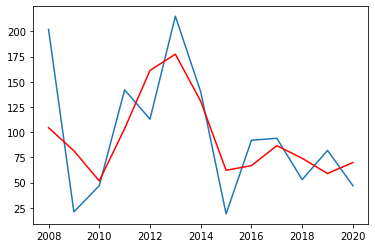

In [77]:

y = np.array(dfu['Value'].tolist())
x = dfu['Year'].tolist()
type(y)
type(x)
yhat = savitzky_golay(y, 5, 3) # window size 5, polynomial order 3

plt.plot(x,y)
plt.plot(x,yhat, color='red')
plt.show()

In [34]:
for u in df['River'].unique():
    print(u)

#baseLine = df.loc[(df['River'] == 'Detroit River') & (df['Year'] == 2008)& (df['Fraction'] == 'Annual TP Loading')]
#baseLine

Cattaraugus Creek
Cedar-Toussaint
Chagrin River
Cuyahoga River
Detroit River (U.S.)
Grand River-OH
Huron River-MI
Huron River-OH
Leamington Tributaries
Maumee River
Portage River
River Raisin
Sandusky River
Thames River
Vermilion River


In [7]:
exdf = pd.read_excel (r'N:\Projects\Blue Accounting\Data Management\ErieStat\GLC_ErieTargetsProgressIndicator_forA4SC.xlsx', sheet_name='SpringData')

In [50]:
exdf

,River,Year,Annual TP load Target,Annual TP load,5yrAvgLoad,5yrAvgReduction,ProgressDial
0,TotalCentralBasin,2008,6000.0,9559.435059,NaN,NaN,NaN
1,TotalCentralBasin,2009,6000.0,7524.153000,NaN,NaN,NaN
2,TotalCentralBasin,2010,6000.0,5207.302000,NaN,NaN,NaN
3,TotalCentralBasin,2011,6000.0,9929.597000,NaN,NaN,NaN
4,TotalCentralBasin,2012,6000.0,7132.540000,NaN,NaN,NaN
...,...,...,...,...,...,...,...
138,Thames River,2016,NaN,284.534000,NaN,-0.742001,-1.855002
139,Thames River,2017,NaN,411.329000,NaN,-0.978148,-2.445371
140,Thames River,2018,NaN,587.912000,NaN,-1.208000,-3.020000
141,Thames River,2019,NaN,672.394000,NaN,-1.330033,-3.325083


In [16]:
for u in df['Fraction'].unique():
    print(u)

Annual TP Loading
Annual TP FWMC
Spring Discharge
Spring TP Loading
Spring SRP Loading
Spring TP FWMC
Spring SRP FWMC
Percent Reduction in Annual TP Load Relative to 2008
5 Year Average of Percent Reduction Relative to 2008
Spring TP Percent Reduction
Spring SRP Percent Reduction
5 Year Average of Spring TP Percent Reduction Relative to 2008
5 Year Average of Spring SRP Percent Reduction Relative to 2008


In [17]:
#make river names match existing json
for index, row in df.iterrows():
    if df.at[index, 'Fraction'] == 'Spring TP Percent Reduction':
        df.at[index, 'Fraction'] = 'Spring TP Percent Reduction Relative to 2008'
    elif df.at[index, 'Fraction'] == 'Spring SRP Percent Reduction':
        df.at[index, 'Fraction'] = 'Spring SRP Percent Reduction Relative to 2008'
    print(df.at[index, 'Fraction'])


Annual TP Loading
Annual TP Loading
Annual TP Loading
Annual TP Loading
Annual TP Loading
Annual TP Loading
Annual TP Loading
Annual TP Loading
Annual TP Loading
Annual TP FWMC
Annual TP FWMC
Annual TP FWMC
Annual TP FWMC
Annual TP FWMC
Annual TP Loading
Annual TP Loading
Annual TP Loading
Spring Discharge
Spring Discharge
Spring Discharge
Spring Discharge
Spring Discharge
Spring Discharge
Spring Discharge
Spring Discharge
Spring Discharge
Spring Discharge
Spring Discharge
Spring Discharge
Spring Discharge
Spring TP Loading
Spring TP Loading
Spring TP Loading
Spring TP Loading
Spring TP Loading
Spring TP Loading
Spring TP Loading
Spring TP Loading
Spring TP Loading
Spring TP Loading
Spring TP Loading
Spring TP Loading
Spring TP Loading
Spring SRP Loading
Spring SRP Loading
Spring SRP Loading
Spring SRP Loading
Spring SRP Loading
Spring SRP Loading
Spring SRP Loading
Spring SRP Loading
Spring SRP Loading
Spring SRP Loading
Spring SRP Loading
Spring SRP Loading
Spring SRP Loading
Spring 

Percent Reduction in Annual TP Load Relative to 2008
Percent Reduction in Annual TP Load Relative to 2008
Percent Reduction in Annual TP Load Relative to 2008
Percent Reduction in Annual TP Load Relative to 2008
Percent Reduction in Annual TP Load Relative to 2008
Percent Reduction in Annual TP Load Relative to 2008
Percent Reduction in Annual TP Load Relative to 2008
Percent Reduction in Annual TP Load Relative to 2008
Percent Reduction in Annual TP Load Relative to 2008
5 Year Average of Percent Reduction Relative to 2008
5 Year Average of Percent Reduction Relative to 2008
5 Year Average of Percent Reduction Relative to 2008
5 Year Average of Percent Reduction Relative to 2008
5 Year Average of Percent Reduction Relative to 2008
5 Year Average of Percent Reduction Relative to 2008
5 Year Average of Percent Reduction Relative to 2008
5 Year Average of Percent Reduction Relative to 2008
5 Year Average of Percent Reduction Relative to 2008
5 Year Average of Percent Reduction Relative t

In [13]:
#calculate spring TP and SRP % reductions
for u in exdf['River'].unique():
    appendList = []
    print(u)
# if it's a river with annual loading data going back to 2008
    #pctred = exdf.loc[(exdf['River'] == u) & (exdf['Year'] == x)]
    if u == 'Portage River':
        TPbaseLine = 195
    else:
        TPbaseLine = df.loc[(df['River'] == u) & (df['Year'] == 2008)& (df['Fraction'] == 'Spring TP Loading')]
        TPbaseLine = TPbaseLine['Value'].iloc[0]
    dfu = df.loc[(df['River'] == u) & (df['Fraction'] == 'Spring TP Loading')]
    for index, row in dfu.iterrows():
        TPpctred = 100*(1-(row['Value']/TPbaseLine))
        print(TPpctred)
        appendList.append([u, row['Year'],'Spring TP Percent Reduction', TPpctred, 'Santina and Maccoux'])        
    if u == 'Portage River':
        SRPbaseLine = 37
    else:
        SRPbaseLine = df.loc[(df['River'] == u) & (df['Year'] == 2008)& (df['Fraction'] == 'Spring SRP Loading')]
        SRPbaseLine = SRPbaseLine['Value'].iloc[0]
    dfu = df.loc[(df['River'] == u) & (df['Fraction'] == 'Spring SRP Loading')]
    for index, row in dfu.iterrows():
        SRPpctred = 100*(1-(row['Value']/SRPbaseLine))
        print(SRPpctred)
        appendList.append([u, row['Year'],'Spring SRP Percent Reduction', SRPpctred, 'Santina and Maccoux'])
    df_length = len(df)
    for i in range(len(appendList)):
        df.loc[df_length+i] = appendList[i]       



Maumee River
0.0
3.139806237182652
7.545435259175437
-63.9198076515098
72.20422883813026
11.639912311717692
18.30634325719538
-45.650236899794926
46.588642953115055
-34.71465950074253
23.69705112792588
-44.400678877024255
0.6435188459090524
0.0
30.13068651778329
-7.12655086848637
-42.26633581472292
78.90818858560795
4.413564929693958
-1.399503722084372
-101.48883374689825
52.36393713813069
-32.00992555831266
28.205128205128204
-14.292803970223321
28.86683209263854
Portage River
nan
nan
nan
12.102564102564095
83.58974358974359
63.12820512820512
68.0
42.87179487179487
65.48717948717947
41.02564102564102
64.61538461538461
24.615384615384617
52.3076923076923
nan
nan
nan
11.891891891891893
82.16216216216216
40.810810810810814
61.891891891891895
-8.378378378378383
70.27027027027026
21.62162162162162
59.45945945945945
21.62162162162162
64.86486486486487
Sandusky River
0.0
45.05314799672935
15.072226764786034
-91.00572363041701
61.106568547288084
0.6813845734532586
26.464976832924492
10.357045

In [15]:
#replace the SG rolling averages with the 5-year averages from Santina
for u in exdf['River'].unique():
    for x in exdf['Year'].unique():
        print(u, x)
        appendList = []
    # if it's a river with annual loading data going back to 2008
        #pctred = exdf.loc[(exdf['River'] == u) & (exdf['Year'] == x)]
        TP5ypctred = exdf.loc[(exdf['River'] == u) & (exdf['Year'] == x), ['5yrAvgSpringTPloadReduction']].iloc[0].iloc[0]*100
        SRP5ypctred = exdf.loc[(exdf['River'] == u) & (exdf['Year'] == x), ['5yrAvgSRPloadReduction']].iloc[0].iloc[0]*100
        print("new values: ", TP5ypctred, SRP5ypctred)
        appendList.append([u, x,'5 Year Average of Spring TP Percent Reduction Relative to 2008', TP5ypctred, 'Santina and Maccoux'])  
        appendList.append([u, x,'5 Year Average of Spring SRP Percent Reduction Relative to 2008', TP5ypctred, 'Santina and Maccoux']) 
        df_length = len(df)
        for i in range(len(appendList)):
            df.loc[df_length+i] = appendList[i]       


Maumee River 2008
new values:  nan nan
Maumee River 2009
new values:  nan nan
Maumee River 2010
new values:  nan nan
Maumee River 2011
new values:  nan nan
Maumee River 2012
new values:  nan nan
Maumee River 2013
new values:  6.122573381948193 12.8125299833582
Maumee River 2014
new values:  9.156415210153689 6.506711309474566
Maumee River 2015
new values:  -1.483337906298532 -12.365815166864635
Maumee River 2016
new values:  20.618128176914354 6.560044466354109
Maumee River 2017
new values:  -0.7655002305340108 -15.623438797555679
Maumee River 2018
new values:  1.6459280337852378 -10.865075715216843
Maumee River 2019
new values:  -10.89537602581212 -13.443923858062835
Maumee River 2020
new values:  -1.6302421039334325 12.607757887227267
Portage River 2008
new values:  nan nan
Portage River 2009
new values:  nan nan
Portage River 2010
new values:  nan nan
Portage River 2011
new values:  nan nan
Portage River 2012
new values:  nan nan
Portage River 2013
new values:  52.947863247863246 44

In [128]:
#df.loc[796].iat[3]
df.loc[796, 'Value']

-8.604228441e-16

In [33]:
df.drop(df[df['Fraction'] == '5 Year Average of Percent Reduction Relative to 2008'].index, inplace = True)


df

,River,Year,Fraction,Value,Source
0,Cattaraugus Creek,2008,Annual TP Loading,NaN,Santina and Maccoux
1,Cattaraugus Creek,2009,Annual TP Loading,44.000000,Santina and Maccoux
2,Cattaraugus Creek,2010,Annual TP Loading,36.000000,Santina and Maccoux
3,Cattaraugus Creek,2011,Annual TP Loading,476.000000,Santina and Maccoux
4,Cattaraugus Creek,2012,Annual TP Loading,559.000000,Santina and Maccoux
...,...,...,...,...,...
752,Vermilion River,2009,Annual TP FWMC,0.092180,Santina and Maccoux
753,Vermilion River,2010,Annual TP FWMC,0.269369,Santina and Maccoux
754,Vermilion River,2011,Annual TP FWMC,0.376533,Santina and Maccoux
755,Vermilion River,2012,Annual TP FWMC,0.404886,Santina and Maccoux
